# CMPT 413 Final Project: Sentiment Analysis Comparison on Web Scraped News Data For Stock Stracking -- A Comparative Analysis Between RNNs for Sentiment Classification.

# The Aim

Financial speculation on companies can be a pretty difficult and time-consuming thing to do. For our final project, we set out to accomplish two things: 

1. Determine which RNN model performs best for sentiment classfication of financial text data and why. 

    This involved making two different models and tuning both such that they have the most fair comparison between 
    their baselines. We opted to test RNN models because their inputs can be plain text handled by relatively simple 
    text-filtering and don't require any external labelling to have decent results for a user. This is why we opted
    to use and compare RNN models for this task rather than more effective Sequence-to-Sequence models which require
    input data to be labelled.


2. Create a program in which a user can simply choose the which RNN model to use based on which has the best results and simply copy paste links they want to examine in order to make a relatively certain conclusion about the overall sentiment of an article without having to spend the time reading it themselves.

    The user simply needs to paste their links into a text file. Run the webscraper to grab the article's text 
    and then runthe model and they will have a relatively certain conclusion about the overall sentiment of the 
    article of interest. This is designed to be automated time-saver for the user to do financial speculation.

    For interpreting our results into financial data, it would be very difficult to make a prediction of exactly how 
    much a given stock may go up or down for a company. If we could do this with certainty, we would be rich. 
    So, for the sake of interpreting the data, an overall positive sentiment means we may expect the stock to be 
    bull-ish (increasing > 1.5%), if it is negative overall we expect it to be bear-ish (decreasing > 1.5%). Neutral
    sentiments to us suggest the stock is subject to the typical ebb and flow of the market and could go slightly up
    or slightly down (-1.5% < x < 1.5%). 

In [2]:
from SentimentDataModels import *
import tqdm as notebook_tqdm
from keras.optimizers import SGD
from keras.utils import pad_sequences, to_categorical

/home/mynahcode/nlpclass-1227-g-quanteam/finalproject/finalproject/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Our Training/Test Dataset: Hugging Face's financial_phrasebank Sentiment Dataset

Originally, we planned to create our own unlabelled dataset purely from sentiment data due to having difficulties finding a dataset which used sentences from financial news articles and headlines. Fortunately, we were able to find at the last minute a dataset from Hugging Face which has exactly what we needed to train more robust Recurrent Neural Network models which can differentiate between Positive, Negative, and Neutral Sentiments. This enabled us to have a larger dataset, not only from just financial articles within certain sectors, but many other financial sectors which contributed to our models being more robust and less biased to a particular type of information.

After some trial and error, we ultimately went with the financial_phrasebank dataset from Hugging Face named sentence_75agree. This dataset provided us with more data to work with than all agree.

For turning this training data text into inputs for our model, we Tokenize the text using the nltk library's Tokenizer and turn the sentences into sequences with appropriate padding so they are all the same length. Due to the increased size of our new dataset, we opted to use our original 70/30 testing-training split. Our text-filtering is quite stringent, removing as many stopwords as we reasonably can by concatenating two stopwords datasets and filtering the dataset and web scraped text through them along with removal of punctuation, and common useless words within the dataset.

In [3]:
# Training Dataset Clean up
nltk_stopwords_english = list(stopwords.words('english'))
stopwords_english = list(get_stop_words('en'))
stopwords_english.extend(nltk_stopwords_english)

# Architecture
output_dim = 50
dropout = 0.2
num_epochs = 5
max_len = 32
batch_size = 64
opt = SGD(learning_rate=0.001) # Set learning_rate to 0.01
classes = 3
train_test_split = 0.7

In [7]:
def loadTrainingData(train_split):
    corpus = []
    dataset = load_dataset("financial_phrasebank", "sentences_75agree") # Labels: 0 -> Negative, 1 -> Neutral, 2 -> Positive
    training_data = dataset['train']
    df = training_data.data.select_columns([0,1]).to_pandas()
    
    i=0
    for sentence in df['sentence']:
        sent = sentence.lower()
        # replace hyphenated words with spaces to dileniate words
        sent = sent.replace("'", "")
        sent = sent.replace("—", "")
        sent = sent.replace("–", "")
        sent = sent.replace("-", "")
        sent = sent.replace("-", "") 
        sent = sent.replace('eur', '')
        sent = sent.replace('mn', '')
        sent = re.sub(r"[^\w\s]", "", sent) # Remove punctuation
        sent = re.sub(r"[0-9]+", "", sent) # Remove digits
        sent = re.sub(r'\s+', ' ', sent) # remove new-line characters
        sent = re.sub(r"\'", "", sent) # remove single quotes
        sent = ' '.join([word for word in sent.split() if len(word) > 1 and sent not in stopwords_english]) #Dont worry about words 'a' or 'i'
        df.loc[i,['sentence']] = [sent]
        i += 1

    i = 0
    for sentence in df['sentence']:
        sentence_word_tokens = word_tokenize(df['sentence'][i])
        corpus += [sentence_word_tokens]
        i += 1
    corpus = sum(corpus, [])

    vocab_size = len(corpus)
    tokenizer = Tokenizer(vocab_size)
    train_size = int(df.shape[0] * train_split)
     
    x_train = df.sentence[:train_size]
    y_train = df.label[:train_size]
    
    x_test = df.sentence[train_size:]
    y_test = df.label[train_size:]
    
    #print(f"x_train: \n {x_train}\n") 
    #print(f"y_train: \n {y_train}\n")
    #print(f"x_test: \n {x_test} \n")
    #print(f"y_test: \n {y_test} \n")
    
    tokenizer.fit_on_texts(x_train)
    x_train = tokenizer.texts_to_sequences(x_train)
    x_train = pad_sequences(x_train, max_len, truncating='post', padding='post')
    
    print(f"DEBUG: x_train[0] = {x_train[0]}, with length = {len(x_train[0])}")
    
    x_test = tokenizer.texts_to_sequences(x_test)
    x_test = pad_sequences(x_test, max_len, truncating='post', padding='post')
    
    y_train = to_categorical(y_train,3)
    y_test = to_categorical(y_test,3)
    
    print(f"DEBUG: x_train.shape = {x_train.shape}. y_train.shape = {y_train.shape}")
    print(f"DEBUG: x_test.shape = {x_test.shape}. y_test.shape = {y_test.shape}")
    
    return x_train, y_train, (x_test, y_test), vocab_size


if __name__ == '__main__':

    x_train, y_train, (x_test, y_test), vocab_size  = loadTrainingData(train_test_split)

Found cached dataset financial_phrasebank (/home/mynahcode/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 768.19it/s]


DEBUG: x_train[0] = [  75    5 1998    1    9   18  133  495    5  542  116   96    5  104
 1999   26    7  543    1    9    7  798    0    0    0    0    0    0
    0    0    0    0], with length = 32
DEBUG: x_train.shape = (2417, 32). y_train.shape = (2417, 3)
DEBUG: x_test.shape = (1036, 32). y_test.shape = (1036, 3)


# RNN 1: Our LSTM Model

We use categorical cross entropy as a means to measure the loss because because we are doing multiclass classification for sentiment classes (Positive, Negative,
and Neutral).

Found cached dataset financial_phrasebank (/home/mynahcode/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1098.27it/s]


DEBUG: x_train[0] = [  75    5 1998    1    9   18  133  495    5  542  116   96    5  104
 1999   26    7  543    1    9    7  798    0    0    0    0    0    0
    0    0    0    0], with length = 32
DEBUG: x_train.shape = (2417, 32). y_train.shape = (2417, 3)
DEBUG: x_test.shape = (1036, 32). y_test.shape = (1036, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 50)            3034550   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 3,054,903
Trainable params: 3,054,903
Non-trainable params: 0
______________________________________________________

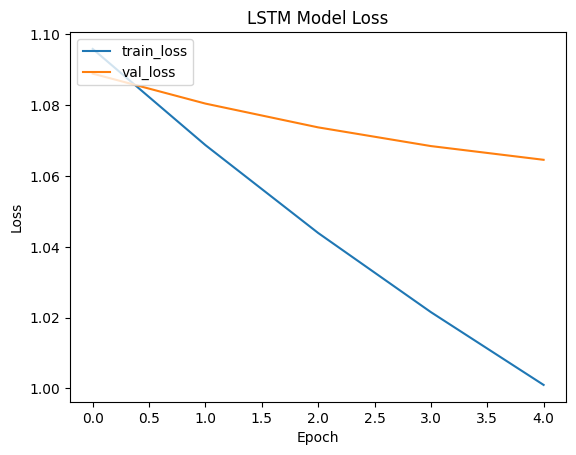

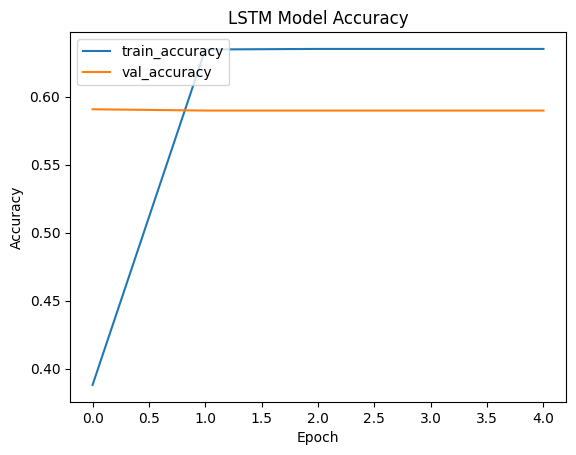

In [5]:
def SentimentModelLSTM(x_train, y_train, testing_data, vocab_size):
    sentiment_model = Sequential()
    sentiment_model.add(Embedding(input_dim=vocab_size, output_dim=output_dim, input_length = x_train.shape[1]))
    sentiment_model.add(LSTM(output_dim, dropout=dropout, recurrent_dropout=0.2)) #LSTM w/ 100 memory units
    sentiment_model.add(Dense(classes, activation="softmax"))
    sentiment_model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    sentiment_model.summary()
    
    history = sentiment_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=testing_data, verbose=2)
    test_history = sentiment_model.evaluate(x_test, y_test)
    
    print(f"Test Score: {test_history[0]}")
    print(f"Test Accuracy: {test_history[1]}")
    
    # Plotting Results -- Loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'], loc='upper left')
    plt.show()
    # Accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('LSTM Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
    plt.show()
    
    return sentiment_model

if __name__ == '__main__':

    x_train, y_train, (x_test, y_test), vocab_size = loadTrainingData(train_test_split)
    sentiment_modelLSTM = SentimentModelLSTM(x_train, y_train, (x_test, y_test), vocab_size)

# RNN 2: SimpleRNN

Found cached dataset financial_phrasebank (/home/mynahcode/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 821.93it/s]


DEBUG: x_train[0] = [  75    5 1998    1    9   18  133  495    5  542  116   96    5  104
 1999   26    7  543    1    9    7  798    0    0    0    0    0    0
    0    0    0    0], with length = 32
DEBUG: x_train.shape = (2417, 32). y_train.shape = (2417, 3)
DEBUG: x_test.shape = (1036, 32). y_test.shape = (1036, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 50)            3034550   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 3,039,753
Trainable params: 3,039,753
Non-trainable params: 0
____________________________________________________

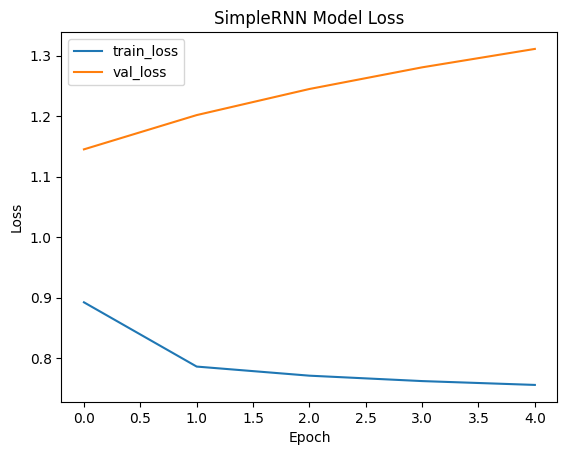

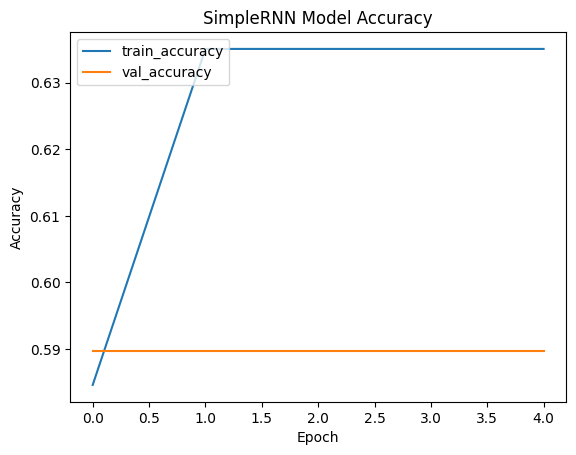

In [8]:
def SentimentModelSimpleRNN(x_train, y_train, testing_data, vocab_size):
    sentiment_model = Sequential()
    sentiment_model.add(Embedding(input_dim=vocab_size, output_dim=output_dim, input_length = x_train.shape[1]))
    sentiment_model.add(SimpleRNN(output_dim, input_length = x_train.shape[1]))
    sentiment_model.add(Dense(3,activation='softmax'))
    
    sentiment_model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    sentiment_model.summary()
    
    history = sentiment_model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=testing_data, verbose=1)
    test_history = sentiment_model.evaluate(x_test, y_test)
    
    print(f"Test Score: {test_history[0]}")
    print(f"Test Accuracy: {test_history[1]}")
    
    # Plotting Results -- Loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SimpleRNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'], loc='upper left')
    plt.show()
    # Accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SimpleRNN Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
    plt.show()

    return sentiment_model
    
if __name__ == '__main__':

    x_train, y_train, (x_test, y_test), vocab_size = loadTrainingData(train_test_split)
    sentiment_modelRNN = SentimentModelSimpleRNN(x_train, y_train, (x_test, y_test), vocab_size)

# Testing our models with web scraped data for sentiment analysis

In [6]:
def TestModelsQualitative(testFile, LSTM_model, RNN_model):
    file = open(testFile)
    tokenizer = Tokenizer(vocab_size)
    for sentence in file:
        input_seq = tokenizer.texts_to_sequences(sentence)
        x_test = pad_sequences(input_seq, max_len)
        print(f"\n\nTest result for sentiment sentence on LSTM and RNN Model: {sentence}\n")
        y_testLSM = LSTM_model.predict(x_test, batch_size=1, verbose = 2)[0]
        y_testRNN = RNN_model.predict(x_test, batch_size=1, verbose = 2)[0]
        if(np.argmax(y_testLSM) == 0):
            print("Predicted Sentiment LSTM: Negative")
            #print(f"Prediction: {y_testLSM}\n")
        elif(np.argmax(y_testLSM) == 1):
            print("Predicted Sentiment LSTM: Positive")
        if(np.argmax(y_testRNN) == 0):
            print("Predicted Sentiment RNN: Negative")
        elif(np.argmax(y_testRNN) == 1):
            print("Predicted Sentiment RNN: Positive")
    
            
if __name__ == '__main__':

    x_train, y_train, (x_test, y_test), vocab_size = loadTrainingData(train_test_split)
    sentiment_modelLSTM = SentimentModelLSTM(x_train, y_train, (x_test, y_test), vocab_size)
    sentiment_modelRNN = SentimentModelSimpleRNN(x_train, y_train, (x_test, y_test), vocab_size)
    
    TestModelsQualitative("./data/test.txt", sentiment_modelLSTM, sentiment_modelRNN)

Found cached dataset financial_phrasebank (/home/mynahcode/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 665.55it/s]


DEBUG: x_train[0] = [  75    5 1998    1    9   18  133  495    5  542  116   96    5  104
 1999   26    7  543    1    9    7  798    0    0    0    0    0    0
    0    0    0    0], with length = 32
DEBUG: x_train.shape = (2417, 32). y_train.shape = (2417, 3)
DEBUG: x_test.shape = (1036, 32). y_test.shape = (1036, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 50)            3034550   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 3,054,903
Trainable params: 3,054,903
Non-trainable params: 0
____________________________________________________

NameError: name 'x_test' is not defined

# For our web scraping of test inputs

In [ ]:
def fetchTextURL(url):
    paragraph_list = []
    #sentences = []
    html = requests.get(url)
    html_content = html.content 
    soup_html = bs(html_content, 'html.parser')
    paragraph = " "
    ptext= soup_html.find_all('p', _class=None)
    # Process text line by line.
    for paragraph in ptext:
        paragraph = paragraph.get_text()
        paragraph = paragraph.lower()
        paragraph = paragraph.replace("Read more:", "") # Useless phrase for model
        paragraph = paragraph.replace("iii", "") # replace edge cases of names such as John Doe III
        paragraph = paragraph.replace("ii", "") # replace edge cases of names such as John Doe II
        paragraph = paragraph.replace("\xa0", " ")
        # replace hyphenated words with spaces to dileniate words
        paragraph = paragraph.replace("—", " ")
        paragraph = paragraph.replace("–", " ")
        paragraph = paragraph.replace("-", " ")
        paragraph = paragraph.replace("-", " ") 
        paragraph = re.sub(r"[^\w\s]", "", paragraph) # Remove punctuation
        paragraph = re.sub(r"[0-9]+", "", paragraph) # Remove digits
        paragraph = re.sub(r'\s+', ' ', paragraph) # remove new-line characters
        paragraph = re.sub(r"\'", "", paragraph) # remove single quotes
        
        """
        paragraph = re.sub(r"\[\d+\]", "", paragraph)
        paragraph = re.sub(r"\[\w+\]", "", paragraph)
        paragraph = re.sub(r"[0-9]+", "", paragraph)
        paragraph = paragraph.replace("*", "")
        paragraph = paragraph.replace("%", "")
        paragraph = paragraph.replace("$", "")
        paragraph = paragraph.replace("@", "")
        paragraph = paragraph.replace("(", "")
        paragraph = paragraph.replace(")", "")
        paragraph = paragraph.replace("—", " ")
        paragraph = paragraph.replace("–", " ")
        paragraph = paragraph.replace("-", " ") # replace hyphenated words with just a space between
        paragraph = paragraph.replace("\n", "")
        paragraph = paragraph.replace("-", " ")
        paragraph = paragraph.replace("\t", "")
        paragraph = paragraph.replace("“", "")
        paragraph = paragraph.replace("”", "")
        paragraph = paragraph.replace(",", "")
        paragraph = paragraph.replace("'", "")
        paragraph = paragraph.replace("’", "")
        paragraph = paragraph.replace(".", "")
        paragraph = paragraph.replace(",", "")
        paragraph = paragraph.replace("?", "")
        paragraph = paragraph.replace("!", "")
        paragraph = paragraph.replace(":", "")
        paragraph = paragraph.replace(";", "")
        paragraph = paragraph.replace("#", "")
        paragraph = paragraph.replace('"', "")
        paragraph = paragraph.replace("/", "")
        paragraph = paragraph.replace("\xa0", " ")
        """
        paragraph_list.append(paragraph)
    paragraph_list_noEmpty = [c for c in paragraph_list if c != ' ' and c != '']
    cleaned_text = [word for word in paragraph_list_noEmpty if word not in stopwords_english] #stopwords removed
    #cleaned_sentences = " ".join(word for word in paragraph if word not in paragraph_list_noEmpty)
    return cleaned_text

def readLinksCSV(linksFile):
    text_data = []
    df = pd.read_csv(linksFile)
    df = df.dropna() # remove N/A rows in dataframe
    
    for link in df['urls']:
        link_text = fetchTextURL(link)
        text_data += link_text
    
    return text_data

def writeToCSV(text):
    df = pd.DataFrame(text)
    df.to_csv('scraped_data.csv')